In [1]:
from model import NSFrozenLake
from amalearn.agent import AgentBase
from draw_policy import draw_policy
from plots import plot_total_episode_rewards, plot_regret
from find_max_reward import find_max_reward

import matplotlib.pyplot as plt
import numpy as np

from CONFIG import *

In [2]:
class Agent(AgentBase):
    
    def __init__(self, id, environment, discount, epsilon, actions, episodes=1000, decade_epsilon=False):
        
        self.environment = environment
        self.i_limit, self.j_limit = 4, 4
        self.actions = actions
        self.epsilon = epsilon
        self.start_epsilon = epsilon
        self.decade_epsilon = decade_epsilon
        self.discount = discount
        self.episodes = episodes
        
        self.Q = {}
        self.C = {}
        self.init_Q_C()
        
        self.target_policy = {}
        self.b_policy = {}
        self.update_policies()
        
        super(Agent, self).__init__(id, environment)
        
    def init_Q_C(self):
        
        for i in range(self.i_limit):
            for j in range(self.j_limit):
                for a in self.actions:
                    self.Q[((i, j), a)] = np.random.rand()
                    self.C[((i, j), a)] = 0
                    
    def update_state_t_policy(self, state):
        
        state_qs = [self.Q[(state, a)] for a in self.actions]
        max_q_idx = np.argmax(state_qs)
        
        self.target_policy[state] = np.zeros(len(self.actions))
        self.target_policy[state][max_q_idx] = 1
        
    def update_state_b_policy(self, state):
        
        state_qs = [self.Q[(state, a)] for a in self.actions]
        max_q_idx = np.argmax(state_qs)
        
        self.b_policy[state] = np.zeros(len(self.actions))+(self.epsilon/len(self.actions))
        self.b_policy[state][max_q_idx] += (1-self.epsilon)
                    
    def update_policies(self):
        
        for i in range(self.i_limit):
            for j in range(self.j_limit):
                self.update_state_t_policy((i, j))
                self.update_state_b_policy((i, j))
                        
    def generate_episode(self):
        
        state = self.environment.reset()
        states, actions, rewards = [state], [], []
        while True:
            
            action, next_state, reward, done = self.take_action(state)
            actions.append(action); rewards.append(reward);
            
            if done:
                states.reverse(); actions.reverse(); rewards.reverse();
                return states, actions, rewards
            
            states.append(next_state)
            state = next_state
                    
    def off_policy_mc(self):
        
        total_rewards = []
        for epoch in range(REPS):
            
            self.reset()
            episode_rewards = []
            for e in range(self.episodes):
                
                self.update_policies()
                states, actions, rewards = self.generate_episode()
                
                g, w = 0, 1
                for s, a, r in zip(states, actions, rewards):
                    
                    g += self.discount*g + r
                    self.C[(s, a)] += w
                    self.Q[(s, a)] += (w/self.C[(s, a)])*(g-self.Q[(s, a)])
                    self.update_state_t_policy(s)
                    
                    if a != np.argmax(self.target_policy[s]):
                        break
                        
                    w *= 1/self.b_policy[s][a]
                    
                episode_rewards.append(sum(rewards))
                
                if self.decade_epsilon and (e+1)%20 == 0:
                    self.epsilon *= 0.99
                    
            self.environment.reset()
            total_rewards.append(episode_rewards)
            
        return total_rewards
        
    def take_action(self, state):
        
        action = np.random.choice(self.actions, p=self.b_policy[state])
        next_state, reward, done, _ = self.environment.step(action)
        
        return action, next_state, reward, done
    
    def reset(self):
        
        self.environment.reset()
        self.init_Q_C()
        self.update_policies()
        self.epsilon = self.start_epsilon

In [3]:
environment = NSFrozenLake(studentNum=STUDENT_NUM)
max_expected_reward = find_max_reward(environment)

In [4]:
agent = Agent('1', environment, DISCOUNT, EPSILON, ACTIONS, episodes=EPISODES)
rewards1 = agent.off_policy_mc()

In [5]:
environment.render()
draw_policy(agent.target_policy)


------------------------------
| 0.000 | 0.001 | 0.332 | 0.746 | 
------------------------------
| 0.696 | 0.001 | 0.143 | 0.998 | 
------------------------------
| 0.703 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.861 | 0.401 | 0.128 | 0.000 | 
------------------------------
↓|→|→|→
→|↓|→|↑
↓|→|→|→
←|→|→|↻


In [6]:
agent = Agent('1', environment, DISCOUNT, EPSILON, ACTIONS, episodes=EPISODES, decade_epsilon=True)
rewards2 = agent.off_policy_mc()

In [7]:
environment.render()
draw_policy(agent.target_policy)


------------------------------
| 0.000 | 0.001 | 0.332 | 0.746 | 
------------------------------
| 0.696 | 0.001 | 0.143 | 0.998 | 
------------------------------
| 0.703 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.861 | 0.401 | 0.128 | 0.000 | 
------------------------------
→|↓|←|→
↓|↓|↑|↑
↓|→|↓|↑
↓|←|→|↻


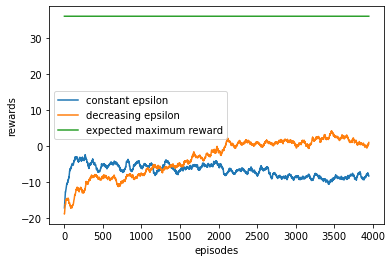

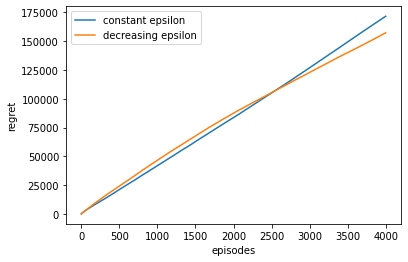

In [8]:
plot_total_episode_rewards(rewards1, rewards2, max_expected_reward, 'constant epsilon', 'decreasing epsilon', window_size=50)
plot_regret(rewards1, rewards2, max_expected_reward, 'constant epsilon', 'decreasing epsilon')